# XGBoost

In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt
from xgboost import XGBClassifier
from numpy import argmax
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, f1_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Dataframes

In [2]:
df_public = pd.read_csv('dados/public.csv')
df_metar = pd.read_csv('dados/metar_2.csv', index_col=0, low_memory=False)

## Tratamento

In [3]:
# variáveis para junção
df_public['data_ref'] = df_public['hora_ref'].apply(lambda x: x[:7])
df_metar['date'] = df_metar['date'].apply(lambda x: x[:7])

In [4]:
df_model = df_public.merge(df_metar, how='left', left_on=['metar', 'data_ref'], right_on=['meta', 'date'])

In [5]:
# variáveis de data
df_model['ano'] = np.int64(df_model['hora_ref'].str[:4])
df_model['mes'] = np.int64(df_model['hora_ref'].str[5:7])
df_model['dia'] = np.int64(df_model['hora_ref'].str[8:10])
df_model['hora'] = np.int64(df_model['hora_ref'].str[11:13])

# variáveis categóricas
df_model['origem'] = df_model['origem'].astype('category')
df_model['destino'] = df_model['destino'].astype('category')

cat_columns = df_model.select_dtypes(['category']).columns
df_model[cat_columns] = df_model[cat_columns].apply(lambda x: x.cat.codes)

## Seleção de variáveis

In [6]:
df_model = df_model[[
    'ano',
    'mes',
    'dia',
    'hora',
    'origem',
    'destino',
    'prev_troca_cabeceira',
    'troca_cabeceira_hora_anterior',
    'espera',
    'latitude',
    'longitude',
    'elevation',
    'wind_direction',
    'wind_speed',
    'visibility',
    'low_cloud_level',
    'cloud_coverage',
    'air_temperature',
    'dew_point_temperature',
    'altimeter',
    'current_wx1_symbol',
    'current_wx2_symbol',
    'current_wx3_symbol',
    'air_pressure_at_sea_level',
    'eastward_wind',
    'northward_wind'
]]

## Datasets de Treino e Teste

In [7]:
# Dataframe para envio na competição
df_test_final = df_model[df_model.espera.isnull()].drop('espera',axis=1)

# Dataframes de treino e teste
df_train_inicial = df_model[~df_model.espera.isnull()]
df_train_inicial = df_train_inicial.dropna()
X_train_inicial = df_train_inicial.drop('espera', axis=1)
y_train_inicial = df_train_inicial['espera']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_inicial, y_train_inicial, test_size=0.20, random_state=42, stratify=y_train_inicial)

## Parâmetros

In [8]:
positives = y_train.sum()
negatives = y_train.shape[0] - y_train.sum()
spw = negatives/positives

In [9]:
spw

56.154421768707486

In [10]:
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'min_child_weight' : hp.lognormal('min_child_weight', 7, 3),
        'n_estimators': hp.quniform('n_estimators', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0.1,  1),
        'scale_pos_weight':hp.quniform('scale_pos_weight', 45, 65, 1),
        'treshold': hp.uniform('treshold', 0.5,  0.8),
    }

In [11]:
# Classifier:
def hyperparameter_tuning(space):
    model = XGBClassifier(n_estimators=int(space['n_estimators']),
                          max_depth = int(space['max_depth']),
                         min_child_weight=int(space['min_child_weight']),
                         learning_rate= space['learning_rate'],
                         objective='binary:logistic',
                         tree_method="auto",
                         scale_pos_weight=space['scale_pos_weight'],
                         enable_categorical=True)
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, 
            verbose=False)

    pred = model.predict(X_test)
    auc = roc_auc_score(y_test, pred>space['treshold'])

    print('Atrasados: ' + str(pred.sum()) + ' || '+ "auc: " + str(auc))
    #change the metric if you like
    return {'loss': 1 - auc, 'status': STATUS_OK, 'model': model}

In [12]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=11354,
            trials=trials)
print(best)

Atrasados: 42009 || auc: 0.5                             
Atrasados: 0 || auc: 0.5                                            
Atrasados: 42009 || auc: 0.5                                        
Atrasados: 11812 || auc: 0.7183331306065093                         
Atrasados: 7087 || auc: 0.7471847177597599                                         
Atrasados: 13004 || auc: 0.7170483864428167                                        
Atrasados: 2333 || auc: 0.7348444393021056                                         
Atrasados: 8828 || auc: 0.7510198642620298                                         
Atrasados: 11427 || auc: 0.7056874268823681                                         
Atrasados: 5309 || auc: 0.7562607482300959                                          
Atrasados: 5093 || auc: 0.7297971841738584                                             
Atrasados: 3520 || auc: 0.7377745835941587                                             
Atrasados: 42009 || auc: 0.5                         

## Treino

In [70]:
bst = XGBClassifier(
    learning_rate= 0.1949090884904199,
      max_depth= 19,
      min_child_weight=187.2734038961501,
      n_estimators= 350,
        scale_pos_weight= 63.0,
    # booster='dart',
    enable_categorical=True)

In [71]:
bst.objective

'binary:logistic'

In [72]:
evalset = [(X_train, y_train), (X_test,y_test)]

_ = bst.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

C:\Users\Eduardo\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67261	validation_1-logloss:0.67405
[1]	validation_0-logloss:0.61762	validation_1-logloss:0.62108
[2]	validation_0-logloss:0.57606	validation_1-logloss:0.58087
[3]	validation_0-logloss:0.54220	validation_1-logloss:0.54802
[4]	validation_0-logloss:0.51382	validation_1-logloss:0.52102
[5]	validation_0-logloss:0.49140	validation_1-logloss:0.49965
[6]	validation_0-logloss:0.47167	validation_1-logloss:0.48060
[7]	validation_0-logloss:0.45425	validation_1-logloss:0.46398
[8]	validation_0-logloss:0.43870	validation_1-logloss:0.44948
[9]	validation_0-logloss:0.42392	validation_1-logloss:0.43563
[10]	validation_0-logloss:0.41161	validation_1-logloss:0.42392
[11]	validation_0-logloss:0.40030	validation_1-logloss:0.41345
[12]	validation_0-logloss:0.38945	validation_1-logloss:0.40283
[13]	validation_0-logloss:0.37911	validation_1-logloss:0.39322
[14]	validation_0-logloss:0.37045	validation_1-logloss:0.38522
[15]	validation_0-logloss:0.36223	validation_1-logloss:0.37739
[1

In [73]:
results = bst.evals_result()

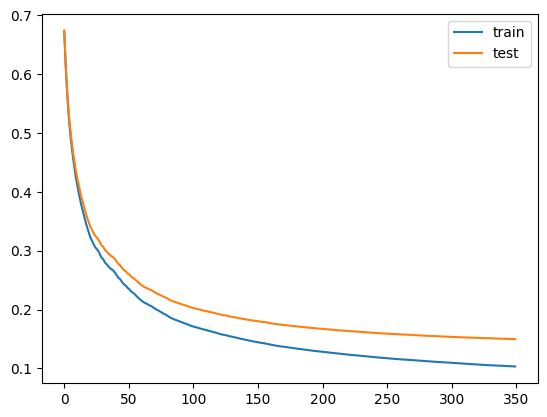

In [74]:
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

## Teste

In [75]:
y_pred = bst.predict_proba(X_test)[:,1]

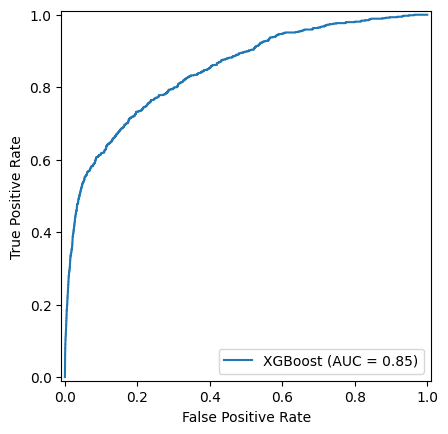

In [76]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='XGBoost')
display.plot()
plt.show()

## Otimização do Threshold Probabilístico

### ROC

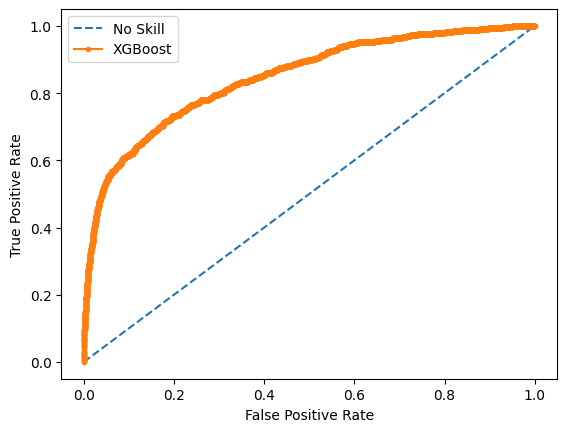

In [77]:
# calcula a curva
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# grafico 
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')

# titulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [78]:
# calcula o melhor ponto 
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)


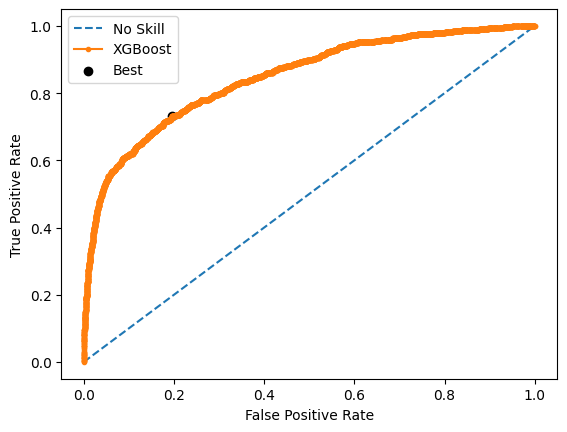

In [79]:
# plota o melhor ponto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# titulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [80]:
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.052929, G-Mean=0.767


### PRC

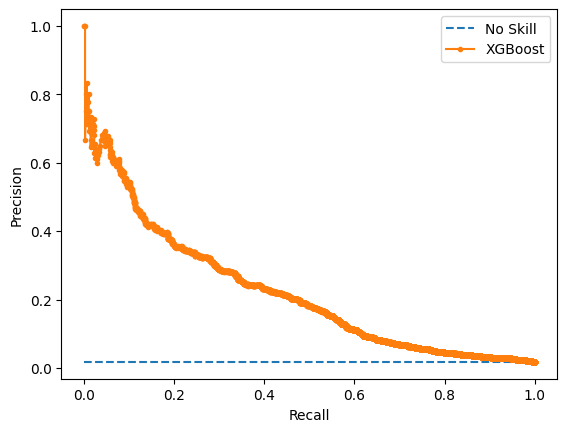

In [81]:
# calcula a curva
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# grafico 
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGBoost')

# titulos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [82]:
# medida F
fscore = (2 * precision * recall) / (precision + recall + 0.00001)

# índice do maior F
ix = argmax(fscore)

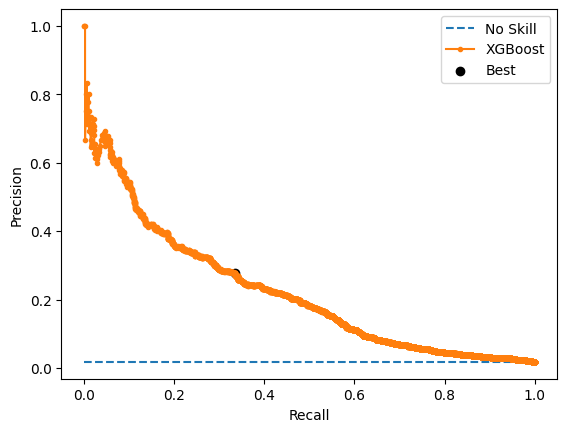

In [83]:
# plota o melhor ponto
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# titulos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [84]:
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.905570, F-Score=0.304


## Submissão

In [107]:
# ids
sub = df_public[df_public.espera.isnull()].drop('espera',axis=1).flightid

# threshold escolhido
threshold = 0.4

# treina o modelo com todos os dados
# bst = XGBClassifier(
#     learning_rate= 0.1949090884904199,
#       max_depth= 19,
#       min_child_weight=187.2734038961501,
#       n_estimators= 19,
#         scale_pos_weight= 63.0,
#     # booster='dart',
#     enable_categorical=True)

# bst.fit(X_train_inicial,y_train_inicial)

# submissao
sub = pd.DataFrame(sub)
y_pred_final = bst.predict_proba(df_test_final)[:,1]
sub['espera'] = np.int8(y_pred_final > threshold)

# informacoes
print(f'Métrica F1 na validação: {f1_score(y_test, np.int8(y_pred > threshold))}')
print(f'{sub.espera.sum()} de {sub.shape[0]} voos classificados como atrasados com threshold {threshold}')


sub.to_csv('submissions/submission_xgboost.csv', index=False)

Métrica F1 na validação: 0.2452012383900929
2086 de 90720 voos classificados como atrasados com threshold 0.4
